### Dataset Development (Market Data OHLCV + TA)

**OHLCV Data:**

- From Enfoque + Nelogica (2017/04 - 2022/07)
  - 1-min time-bars
    - Resampled to Daily and Hourly data


**Technical Indicators:**

- From `ta_lib`
  - SMAs
  - EMAs
  - RSI
  - ADX
  - MACD
  - BBANDS
  - OBV

In [125]:
import os
import numpy as np
import ta as ta_lib
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

pd.options.mode.use_inf_as_na = True

# Quantstats
import quantstats as qs
qs.extend_pandas()

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [126]:
ticker = 'PETR4'

In [127]:
# Get Adjusted 1-min bars
df = pd.read_parquet(f'../../data/market/ohlcv_minute/{ticker}.parquet')
df

,open,high,low,close,qty,volume,status
symbol,PETR4,PETR4,PETR4,PETR4,PETR4,PETR4,PETR4
datetime,,,,,,,
2017-04-13 13:03:00+00:00,9.308286,9.327347,9.301932,9.327347,128000.0,1.191646e+06,0.0
2017-04-13 13:04:00+00:00,9.327347,9.333701,9.320993,9.333701,90200.0,8.416901e+05,0.0
2017-04-13 13:05:00+00:00,9.333701,9.333701,9.320993,9.327347,123400.0,1.151171e+06,0.0
2017-04-13 13:06:00+00:00,9.320993,9.320993,9.308286,9.308286,85600.0,7.974100e+05,0.0
2017-04-13 13:07:00+00:00,9.308286,9.320993,9.308286,9.314640,72100.0,6.715626e+05,0.0
...,...,...,...,...,...,...,...
2022-07-15 19:51:00+00:00,27.970000,28.020000,27.950000,28.010000,109700.0,3.070401e+06,0.0
2022-07-15 19:52:00+00:00,28.020000,28.020000,27.980000,28.010000,142000.0,3.976144e+06,0.0


### Get OHLCV Bars from QFLib

**Output:**

- Daily OHLCV DataFrame
- Hourly OHLCV DataFrame

In [128]:
def load_raw_ohlcv(ticker: str):
    """
    Loads local OHLCV data for ticker.
    Returns two pd.DataFrames: daily resample and hourly resample.
    """

    # Get Adjusted 1-min bars
    df = pd.read_parquet(f'../../data/market/ohlcv_minute/{ticker}.parquet')

    # Adjust Timestamp
    df.index = df.index.tz_convert(None) - pd.Timedelta(hours=3)

    # Filter Trading Hours (10h - 17h)
    hours = df.index.hour
    df = df.iloc[(hours >= 10) & (hours < 17)]

    # Drop level (ticker)
    df.columns = df.columns.droplevel(1)

    # Drop volume
    df = df.drop(columns=['volume'])

    # Rename qty to volume
    df = df.rename(columns={'open': 'Open', 
                            'high': 'High', 
                            'low': 'Low', 
                            'close': 'Close', 
                            'qty': 'Volume'})

    # Rename index
    df.index = df.index.rename('Date')

    # Resample to Daily Bars
    ohlcv_dict_daily = {                                                                                                             
        'Open': 'first',                                                                                                    
        'High': 'max',                                                                                                       
        'Low': 'min',                                                                                                        
        'Close': 'last',
        'Volume': 'sum'
    }

    df_daily = df.resample('1D', closed='left', label='left').apply(ohlcv_dict_daily).dropna()

    # Resample to 1 Hour Bars
    ohlcv_dict_hourly = {                                                                                                             
        'Open': 'first',                                                                                                    
        'High': 'max',                                                                                                       
        'Low': 'min',                                                                                                        
        'Close': 'last',
        'Volume': 'sum'
    }

    df_hourly = df.groupby(pd.Grouper(freq='1h')).agg(ohlcv_dict_hourly).dropna()

    return df_daily, df_hourly

In [129]:
df_daily, df_hourly = load_raw_ohlcv(ticker=ticker)

In [130]:
# Daily Bars
df_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-04-13,9.308286,9.333701,8.958828,8.971535,35923600.0
2017-04-17,8.984243,9.117672,8.876229,9.092257,32298900.0
2017-04-18,8.990597,9.130380,8.863521,8.952474,38687500.0
2017-04-19,9.047781,9.073196,8.609370,8.641139,33865800.0
2017-04-20,8.768215,8.831752,8.660200,8.768215,25946200.0


In [131]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1300 entries, 2017-04-13 to 2022-07-15
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1300 non-null   float64
 1   High    1300 non-null   float64
 2   Low     1300 non-null   float64
 3   Close   1300 non-null   float64
 4   Volume  1300 non-null   float64
dtypes: float64(5)
memory usage: 60.9 KB


In [132]:
# Hourly Bars
df_hourly.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-04-13 10:00:00,9.308286,9.333701,9.232040,9.276517,5071500.0
2017-04-13 11:00:00,9.270163,9.327347,9.251102,9.263809,2983900.0
2017-04-13 12:00:00,9.263809,9.289224,9.193918,9.238394,3914000.0
2017-04-13 13:00:00,9.232040,9.232040,9.181210,9.187564,2352500.0
2017-04-13 14:00:00,9.181210,9.187564,9.066842,9.073196,4217400.0


In [133]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9068 entries, 2017-04-13 10:00:00 to 2022-07-15 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    9068 non-null   float64
 1   High    9068 non-null   float64
 2   Low     9068 non-null   float64
 3   Close   9068 non-null   float64
 4   Volume  9068 non-null   float64
dtypes: float64(5)
memory usage: 425.1 KB


In [134]:
assert df_daily.loc['2018-06-15'].Volume == df_hourly.loc['2018-06-15'].Volume.sum()

---

### Feature Engineering

In [135]:
def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    """
    Calculate MACD indicator.
    """
    
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def generate_all_default_quantstats_features(data):
    """
    Generate all TA from 'quantstats'.
    """
    
    excluded_indicators = [
        'compare',
        'greeks',
        'information_ratio',
        'omega',
        'r2',
        'r_squared',
        'rolling_greeks',
        'warn'
    ]
    
    indicators_list = [f for f in dir(qs.stats) if f[0] != '_' and f not in excluded_indicators]
    
    df = data.copy()
    df = df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)

    for indicator_name in indicators_list:
        try:
            indicator = qs.stats.__dict__[indicator_name](df['Close'])
            if isinstance(indicator, pd.Series):
                indicator = indicator.to_frame(name=indicator_name)
                df = pd.concat([df, indicator], axis='columns')
        except (pd.errors.InvalidIndexError, ValueError):
            print (f'Error on indicator: {indicator_name}')
            pass

    df = df.reset_index()
    return df

def generate_features(data):
    """
    Generate all TA used in the research.
    """

    # Automatically-generated using 'ta_lib'
    df = data.copy()

    df.index = pd.DatetimeIndex(df.index)

    # Generate all default indicators from ta library
    ta_lib.add_all_ta_features(data, 
                            'Open', 
                            'High', 
                            'Low', 
                            'Close', 
                            'Volume', 
                            fillna=True)

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'prev_open': data['Open'].shift(1),
        'prev_high': data['High'].shift(1),
        'prev_low': data['Low'].shift(1),
        'prev_close': data['Close'].shift(1),
        'prev_volume': data['Volume'].shift(1),
        'vol_5': data['Close'].rolling(window=5).std().abs(),
        'vol_10': data['Close'].rolling(window=10).std().abs(),
        'vol_20': data['Close'].rolling(window=20).std().abs(),
        'ma_5': data['Close'].rolling(window=5).mean(),
        'ma_10': data['Close'].rolling(window=10).mean(),
        'ma_20': data['Close'].rolling(window=20).mean(),
        'ema_5': ta_lib.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_10': ta_lib.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_20': ta_lib.trend.ema_indicator(data['Close'], window=20, fillna=True),
        'lr_open': np.log(data['Open']).diff().fillna(0),
        'lr_high': np.log(data['High']).diff().fillna(0),
        'lr_low': np.log(data['Low']).diff().fillna(0),
        'lr_close': np.log(data['Close']).diff().fillna(0),
        'r_volume': data['Close'].diff().fillna(0),
        'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50)
    })

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    data = data.reset_index()
    
    # Revert naming convention
    data = data.rename(columns={'Date': 'date'})

    # Generate all default quantstats features
    df_quantstats = generate_all_default_quantstats_features(data)

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df_quantstats], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    data.set_index('date', inplace=True)

    return data

In [136]:
data_daily = generate_features(df_daily)
# data_hourly = generate_features(df_hourly)

In [137]:
data_daily.head()

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,Volume,compsum,implied_volatility,outliers,pct_rank,remove_outliers,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
date,,,,,,,,,,,,,,,,,,,,,
2017-04-13,9.308286,9.333701,8.958828,8.971535,35923600.0,-3.348810e+07,35923600.0,-0.932203,0.000000e+00,0.000000,...,35923600.0,8.971535,NaN,NaN,100.000000,8.971535,NaN,NaN,NaN,0.000000
2017-04-17,8.984243,9.117672,8.876229,9.092257,32298900.0,-7.988970e+06,68222500.0,-0.117102,3.899181e+06,-0.111616,...,32298900.0,99.635302,NaN,NaN,100.000000,9.092257,NaN,NaN,NaN,0.000000
2017-04-18,8.990597,9.130380,8.863521,8.952474,38687500.0,-2.088480e+07,29535000.0,-0.195349,2.569604e+06,0.000000,...,38687500.0,1000.570238,NaN,NaN,33.333333,8.952474,NaN,NaN,NaN,-0.015374
2017-04-19,9.047781,9.073196,8.609370,8.641139,33865800.0,-5.011145e+07,-4330800.0,-0.355966,6.962870e+05,-0.213202,...,33865800.0,9655.277880,NaN,NaN,25.000000,8.641139,NaN,NaN,NaN,-0.049616
2017-04-20,8.768215,8.831752,8.660200,8.768215,25946200.0,-4.338466e+07,21615400.0,-0.260222,1.067836e+06,-0.063015,...,25946200.0,94323.594278,NaN,NaN,40.000000,8.768215,NaN,NaN,NaN,-0.035639


In [138]:
columns_to_keep = [
    # OHLCV
    'open',
    'high',
    'low',
    'close',
    'volume',
    'prev_open',
    'prev_high',
    'prev_low',
    'prev_close',
    'prev_volume',
    # Volume Indicators (OBV)
    'volume_obv',
    # Momentum Indicators (RSI)
    'momentum_rsi',
    # Strength Indicator (ADX, MACD)
    'trend_adx',
    'trend_macd',
    'trend_macd_signal',
    'trend_macd_diff',
    # Volatility Indicators (BBANDS)
    'volatility_bbm',
    'volatility_bbh',
    'volatility_bbl',
    # Custom Indicators
    'vol_5',
    'vol_10',
    'vol_20',
    'ma_5',
    'ma_10',
    'ma_20',
    'ema_5',
    'ema_10',
    'ema_20',
    'lr_open',
    'lr_high',
    'lr_low',
    'lr_close',
    'r_volume'
]

data_daily_final = data_daily[columns_to_keep]
# data_hourly_final = data_hourly[columns_to_keep]

#### ADX

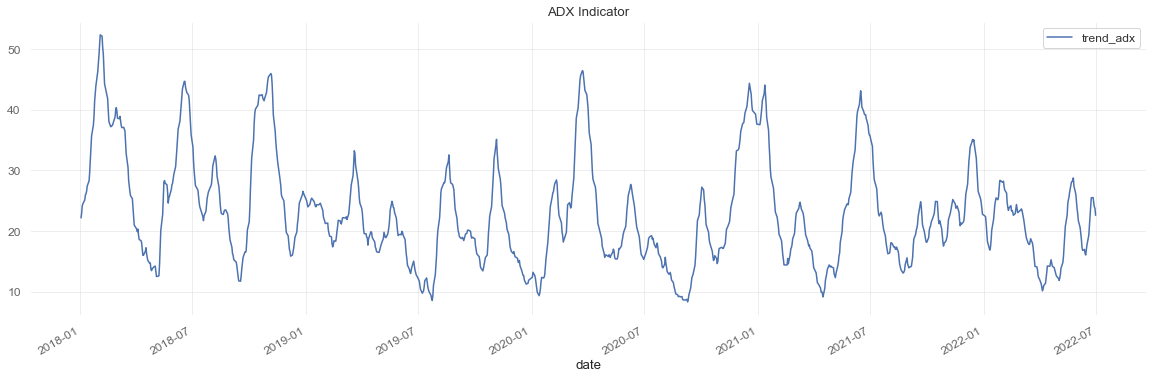

In [139]:
data_daily[['trend_adx']].loc['2018':'2022-07-01'].plot(figsize=(20,6)).set_title('ADX Indicator');

#### BBANDS

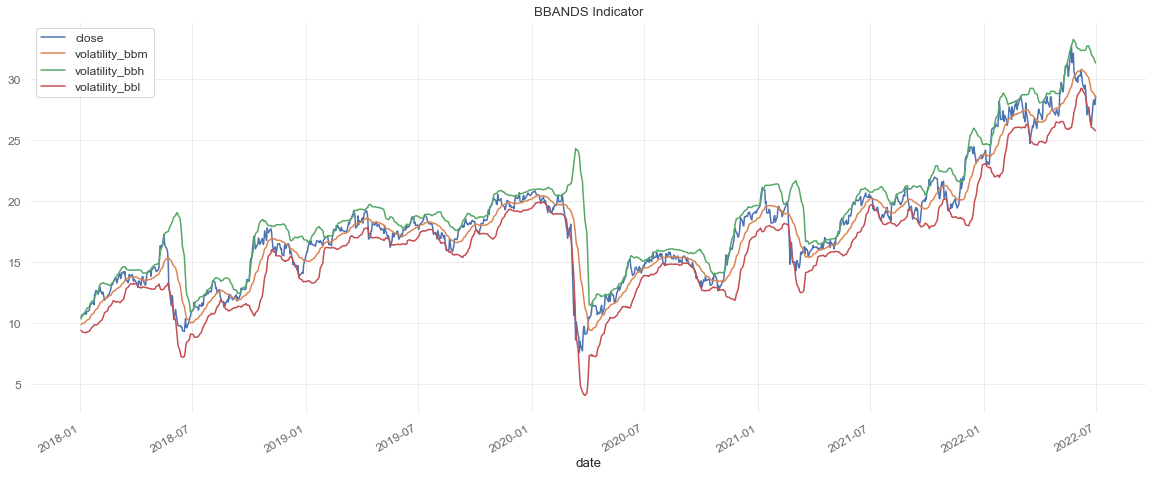

In [140]:
data_daily[['close', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl']].loc['2018':'2022-07-01'].plot(figsize=(20,8)).set_title('BBANDS Indicator');

#### MACD

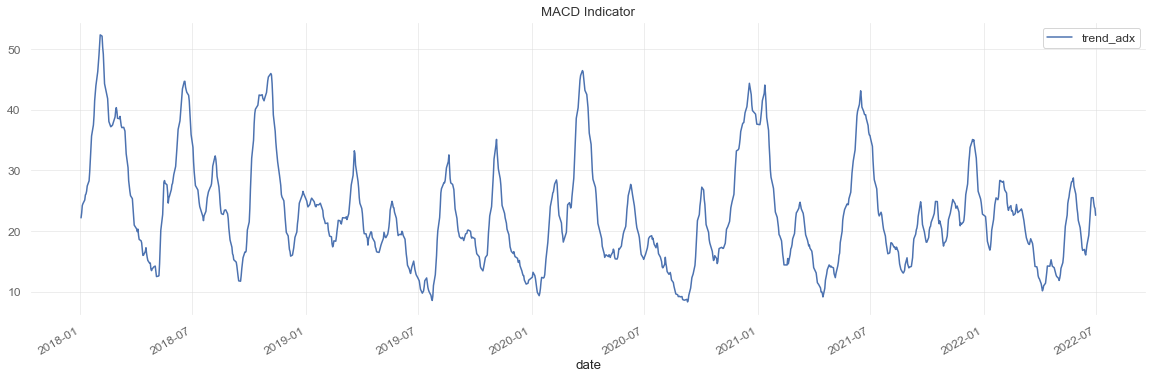

In [141]:
data_daily[['trend_adx']].loc['2018':'2022-07-01'].plot(figsize=(20,6)).set_title('MACD Indicator');

#### RSI

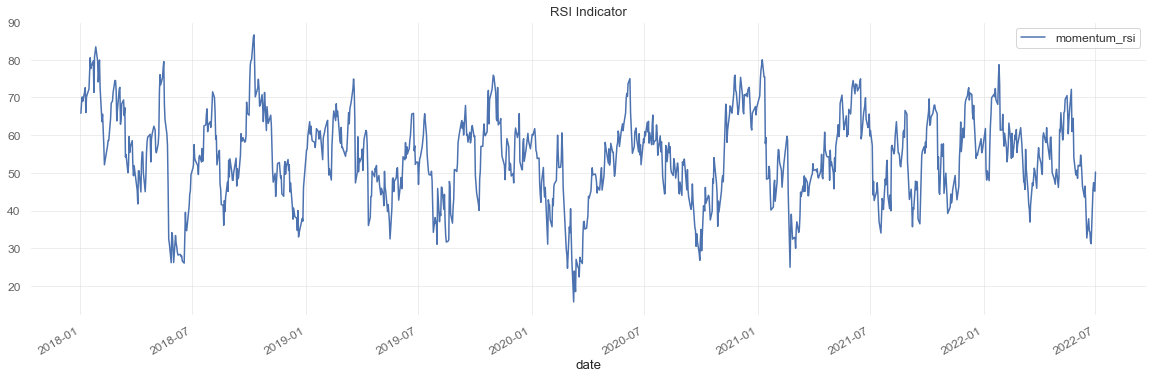

In [142]:
data_daily[['momentum_rsi']].loc['2018':'2022-07-01'].plot(figsize=(20,6)).set_title('RSI Indicator');

#### OBV

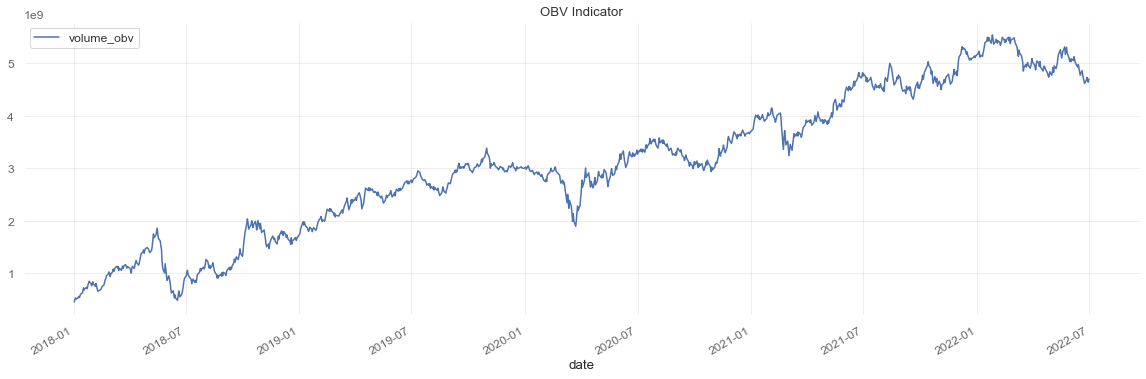

In [143]:
data_daily[['volume_obv']].loc['2018':'2022-07-01'].plot(figsize=(20,6)).set_title('OBV Indicator');

In [144]:
def generate_train_test_datasets(df, ticker, train_test_split, end_test, final_dir, save_csv=False):
    """
    Return Train/Test Splits from specific ticker from Qflib.
    """

    next_day = datetime.strptime(train_test_split, '%Y-%m-%d')
    next_day = next_day + timedelta(days=1)
    next_day = next_day.strftime('%Y-%m-%d')

    df_train = df.loc[:train_test_split].copy()


    next_day_test = datetime.strptime(end_test, '%Y-%m-%d')
    next_day_test = next_day_test + timedelta(days=1)
    next_day_test = next_day_test.strftime('%Y-%m-%d')

    df_test = df.loc[next_day:next_day_test].copy()

    if save_csv:
        df_train.dropna().to_csv(f'../../data/market/{final_dir}/train/{ticker}_train.csv', index=True)
        df_test.dropna().to_csv(f'../../data/market/{final_dir}/test/{ticker}_test.csv', index=True)

    return df_train, df_test

#### Final OHLCV Daily Bars and TA

In [145]:
# Train Dataset (Starts at 2018-01-01 | Ends: 2021-12-31)
st_date = '2018-01-01'
data_daily_final = data_daily_final.loc[st_date:]

# Test Dataset (Starts at 2022-01-01 | Ends: 2022-07-01)
train_test_split = '2022-01-01'
end_test_dt = '2022-07-01'


df_train, df_test = generate_train_test_datasets(
    df=data_daily_final, 
    ticker=ticker, 
    train_test_split=train_test_split,
    end_test=end_test_dt,
    final_dir='ohlcv_daily_TA', 
    save_csv=True)


print ('Train: ', df_train.shape)
print ('Test: ', df_test.shape)

Train:  (989, 33)
Test:  (125, 33)


In [146]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 989 entries, 2018-01-02 to 2021-12-30
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   open               989 non-null    float64
 1   high               989 non-null    float64
 2   low                989 non-null    float64
 3   close              989 non-null    float64
 4   volume             989 non-null    float64
 5   prev_open          989 non-null    float64
 6   prev_high          989 non-null    float64
 7   prev_low           989 non-null    float64
 8   prev_close         989 non-null    float64
 9   prev_volume        989 non-null    float64
 10  volume_obv         989 non-null    float64
 11  momentum_rsi       989 non-null    float64
 12  trend_adx          989 non-null    float64
 13  trend_macd         989 non-null    float64
 14  trend_macd_signal  989 non-null    float64
 15  trend_macd_diff    989 non-null    float64
 16  volatil

In [147]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 125 entries, 2022-01-03 to 2022-07-01
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   open               125 non-null    float64
 1   high               125 non-null    float64
 2   low                125 non-null    float64
 3   close              125 non-null    float64
 4   volume             125 non-null    float64
 5   prev_open          125 non-null    float64
 6   prev_high          125 non-null    float64
 7   prev_low           125 non-null    float64
 8   prev_close         125 non-null    float64
 9   prev_volume        125 non-null    float64
 10  volume_obv         125 non-null    float64
 11  momentum_rsi       125 non-null    float64
 12  trend_adx          125 non-null    float64
 13  trend_macd         125 non-null    float64
 14  trend_macd_signal  125 non-null    float64
 15  trend_macd_diff    125 non-null    float64
 16  volatil

In [148]:
print (f'Quantidade de Dias de Treinamento: {df_train.shape[0]}')
print (f'Quantidade de Dias de Teste: {df_test.shape[0]}')
print (f'Percentual Treino: {round(df_train.shape[0] / (df_train.shape[0] + df_test.shape[0]) * 100, 2)}%')
print (f'Percentual Teste: {round(df_test.shape[0] / (df_train.shape[0] + df_test.shape[0]) * 100, 2)}%')

Quantidade de Dias de Treinamento: 989
Quantidade de Dias de Teste: 125
Percentual Treino: 88.78%
Percentual Teste: 11.22%


---

### Skip Intraday Data (For Now)

In [149]:
# df_train, df_test = generate_train_test_datasets(data_hourly_final, ticker, train_test_split, 'ohlcv_hourly_TA', save_csv=True)
# print ('Train: ', df_train.shape)
# print ('Test: ', df_test.shape)

In [150]:
# # 1. Hourly OHLCV
# data_hourly_final_ohlcv = data_hourly_final[['open', 'high', 'low', 'close', 'volume']]

# # 2. Daily OHLCV with Technical Indicators
# data_daily_final_shifted = data_daily_final.shift().dropna()
# data_daily_final_shifted = data_daily_final_shifted.rename(columns={'open': 'open_d', 'high': 'high_d', 'low': 'low_d', 'close': 'close_d', 'volume': 'volume_d'})

# # 3. Merge Daily OHLCV with Technical Indicators with Hourly OHLCV
# data_daily_hourly = pd.concat([data_hourly_final_ohlcv, data_daily_final_shifted], axis=1).ffill().dropna()

# # Filter trading hours (if necessary)
# hours = data_daily_hourly.index.hour
# data_daily_hourly = data_daily_hourly.iloc[((hours > 10) & (hours <= 17))]

In [151]:
# data_daily_hourly.head(5)

In [152]:
# df_train, df_test = generate_train_test_datasets(data_daily_hourly, ticker, train_test_split, 'ohlcv_daily_hourly_TA', save_csv=True)
# print ('Train: ', df_train.shape)
# print ('Test: ', df_test.shape)

---

In [153]:
# fig, ax = plt.subplots(figsize=(20,6))
# data_daily_hourly.loc[st_year:].close_d.plot(ax=ax)
# data_daily_hourly.loc[st_year:].close.plot(ax=ax)
# ax.set_title(f'{ticker} Closing Prices')
# ax.set_ylabel('Price (R$)')
# ax.set_xlabel('Date')
# plt.legend()
# plt.tight_layout();

---